# **Food_Vision_Big_101_Model**

## **1- Import Libraries**

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **2-Load Helper Function**

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-03-25 16:32:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-25 16:32:38 (78.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## **3-Get Functions From Helper Functions**

In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## **4- Import Data From Tensorflow Datasets**

In [4]:
import tensorflow_datasets as tfds

In [8]:
(train_data, test_data), ds_info = tfds.load(name='food101',
          split=["train", "validation"],
          shuffle_files=True,
           as_supervised=True,
          with_info=True)

## **5-Features of Food101 TFDS**

In [9]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [10]:
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## **6- Exploring the Food101 data from TensorFlow Datasets**

In [11]:
train_one_sample = train_data.take(1)

In [12]:
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 384, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 74
  Class name (str form): peking_duck
        


In [14]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## **8-Plot an image from TensorFlow Datasets**

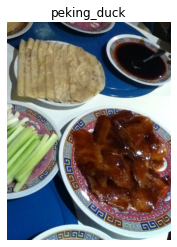

In [15]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) 
plt.axis(False);

## **9-Create preprocessing functions for our data**

In [16]:
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) 
  return tf.cast(image, tf.float32), label

In [17]:
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[152 129  77]
  [160 137  85]
  [160 137  85]
  ...
  [ 26  21  18]
  [ 24  19  16]
  [ 21  16  13]]

 [[156 133  81]
  [158 135  83]
  [155 132  80]
  ...
  [ 25  20  17]
  [ 23  18  15]
  [ 22  17  14]]]...,
Shape: (512, 384, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[156.05103  133.05103   81.05102 ]
  [156.13776  133.13776   81.13776 ]
  [146.31122  123.311226  71.311226]
  ...
  [ 22.454105  17.454105  13.668401]
  [ 25.306135  20.306135  17.306135]
  [ 22.25511   17.25511   14.25511 ]]

 [[159.82652  136.82652   82.82653 ]
  [149.79591  126.79591   72.79591 ]
  [132.69388  109.69388   57.265305]
  ...
  [ 24.183672  19.183672  15.397966]
  [ 22.21425   17.21425   14.214251]
  [ 18.83164   14.83164   11.83164 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


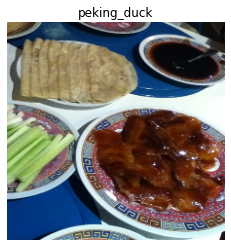

In [19]:
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

## **10-Batch & prepare datasets**

In [20]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [21]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## **11-Create modelling callbacks**

In [22]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_accuracy",
                                                      save_best_only=True, 
                                                      save_weights_only=True, 
                                                      verbose=1) 


## **12-Setup mixed precision training**

In [23]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [24]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## **13-Build feature extraction model**

In [35]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer", dtype=tf.float16)
# x = preprocessing.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 1s 0us/step


In [36]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

## **14-Checking layer dtype policies (are we using mixed precision?)**

In [37]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float16 <Policy "float16">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [38]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 False float32 <Policy "float32">
rescaling_1 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False

## **15-Fit the feature extraction model**

In [39]:
# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=5,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "MobileNetV2_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/MobileNetV2_101_classes_all_data_feature_extract/20220325-172905
Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 1.8229 - accuracy: 0.5579
Epoch 1: val_loss improved from 1.22993 to 1.21837, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 324s 130ms/step - loss: 1.8229 - accuracy: 0.5579 - val_loss: 1.2184 - val_accuracy: 0.6875
Epoch 2/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.2938 - accuracy: 0.6672
Epoch 2: val_loss improved from 1.21837 to 1.12586, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================] - 273s 115ms/step - loss: 1.2938 - accuracy: 0.6672 - val_loss: 1.1259 - val_accuracy: 0.6931
Epoch 3/5
2368/2368 [==============================] - ETA: 0s - loss: 1.1431 - accuracy: 0.7026
Epoch 3: val_loss improved from 1.12586 to 1.09461, saving model to model_checkpoints/cp.ckpt
2368/2368 [==============================

## **16- Evaluate The Model**

In [40]:
# Evaluate model (unsaved version) on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 92s 117ms/step - loss: 1.0657 - accuracy: 0.7112


[1.065735101699829, 0.7111682891845703]

## **17-Load and evaluate checkpoint weights**

In [41]:
# Clone the model we created (this resets all weights)
cloned_model = tf.keras.models.clone_model(model)
cloned_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [42]:
# Load checkpointed weights into cloned_model
cloned_model.load_weights(checkpoint_path)

In [43]:
# Compile cloned_model (with same parameters as original model)
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

## **18-Save the whole model to file**

In [44]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision/assets


INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision/assets


## **19-Loaded Saved Model**

In [48]:
loaded_model = tf.keras.models.load_model('07_efficientnetb0_feature_extract_model_mixed_precision')

## **20-A couple more callbacks**

In [49]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [50]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

## **21-Recompile The Model**

In [51]:
# Compile the model
loaded_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

## **22-Fine Tune The Model**

In [53]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_model.fit(train_data,
                                                        epochs=10, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20220325-180459
Epoch 1/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.8354 - accuracy: 0.7871INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 353s 143ms/step - loss: 0.8354 - accuracy: 0.7871 - val_loss: 1.0351 - val_accuracy: 0.7182 - lr: 1.0000e-04
Epoch 2/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.8218 - accuracy: 0.7919INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 340s 143ms/step - loss: 0.8218 - accuracy: 0.7919 - val_loss: 1.0320 - val_accuracy: 0.7185 - lr: 1.0000e-04
Epoch 3/10
2368/2368 [==============================] - ETA: 0s - loss: 0.8143 - accuracy: 0.7942INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 341s 143ms/step - loss: 0.8143 - accuracy: 0.7942 - val_loss: 1.0282 - val_accuracy: 0.7201 - lr: 1.0000e-04
Epoch 4/10
2368/2368 [==============================] - 271s 113ms/step - loss: 0.8081 - accuracy: 0.7967 - val_loss: 1.0296 - val_accuracy: 0.7198 - lr: 1.0000e-04
Epoch 5/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.8023 - accuracy: 0.7977INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 343s 144ms/step - loss: 0.8023 - accuracy: 0.7977 - val_loss: 1.0280 - val_accuracy: 0.7166 - lr: 1.0000e-04
Epoch 6/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.7971 - accuracy: 0.7994INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


2368/2368 [==============================] - 352s 148ms/step - loss: 0.7971 - accuracy: 0.7994 - val_loss: 1.0203 - val_accuracy: 0.7246 - lr: 1.0000e-04
Epoch 7/10
2368/2368 [==============================] - 276s 116ms/step - loss: 0.7920 - accuracy: 0.8011 - val_loss: 1.0255 - val_accuracy: 0.7206 - lr: 1.0000e-04
Epoch 8/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.7869 - accuracy: 0.8021
Epoch 8: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 272s 114ms/step - loss: 0.7869 - accuracy: 0.8021 - val_loss: 1.0309 - val_accuracy: 0.7214 - lr: 1.0000e-04
Epoch 9/10
2368/2368 [==============================] - 272s 114ms/step - loss: 0.7729 - accuracy: 0.8069 - val_loss: 1.0212 - val_accuracy: 0.7219 - lr: 2.0000e-05


## **23-Save Fine Tune Model**

In [54]:
fine_tune_saved = model.save('07_efficientnetb0_fine_tuned_101_classes_mixed_precision')

INFO:tensorflow:Assets written to: 07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


INFO:tensorflow:Assets written to: 07_efficientnetb0_fine_tuned_101_classes_mixed_precision/assets


## **24-Plot Graphs and Compare Histories**

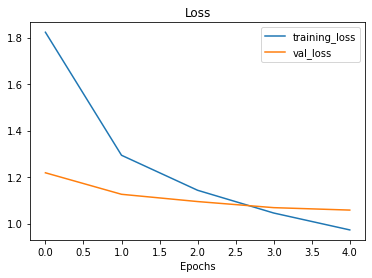

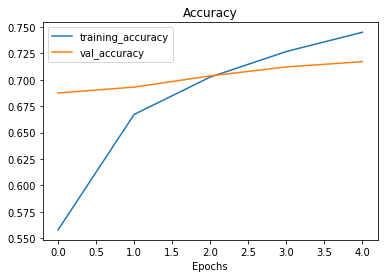

In [55]:
plot_loss_curves(history_101_food_classes_feature_extract)

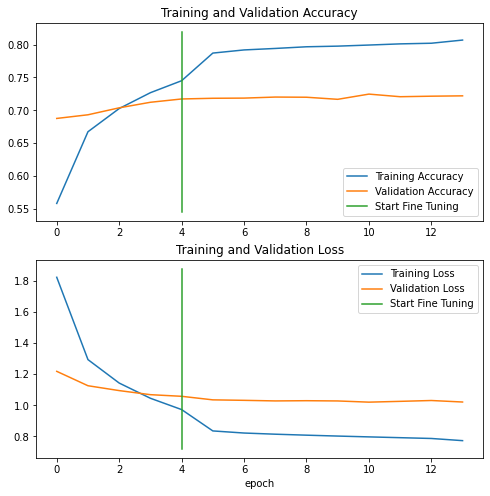

In [57]:
compare_historys(history_101_food_classes_feature_extract, history_101_food_classes_all_data_fine_tune)

## **25-View training results on TensorBoard**

In [59]:
!tensorboard dev upload --logdir ./training_logs \
  --name "Fine-tuning EfficientNetB0 on all Food101 Data" \
  --description "Training results for fine-tuning EfficientNetB0 on Food101 Data with learning rate 0.0001" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=VqpUoF6FFfjvt9cw9BKbqknB6IEF5B&prompt=consent&access_type=offli